In [1]:
!pip -q install torchxrayvision

     |████████████████████████████████| 29.0 MB 70.1 MB/s 


In [2]:
import skimage, torch, torchvision
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torchxrayvision as xrv
from torch import Tensor
from torch import nn
from random import shuffle
import cv2
from google.colab.patches import cv2_imshow
import torchvision
import pandas as pd                     


import time
from torch import optim
import torch
from torch import nn
from torch import optim
from torch.cuda import amp
from torch.optim import lr_scheduler
from torch.optim.swa_utils import AveragedModel
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot


In [3]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 32.05 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Checking out files: 100% (1174/1174), done.


In [4]:
d = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [5]:
import matplotlib.pyplot as plt

In [6]:
sample = d[12]

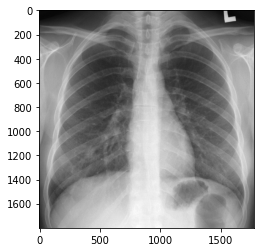

In [7]:
plt.imshow(sample["img"][0], cmap="gray");

In [8]:
import pandas as pd
pd.Series(dict(zip(d.pathologies,sample["lab"])))

Aspergillosis     0.0
Aspiration        0.0
Bacterial         0.0
COVID-19          0.0
Chlamydophila     0.0
Fungal            0.0
H1N1              0.0
Herpes            0.0
Influenza         0.0
Klebsiella        0.0
Legionella        0.0
Lipoid            0.0
MERS-CoV          0.0
MRSA              0.0
Mycoplasma        0.0
No Finding        0.0
Nocardia          0.0
Pneumocystis      0.0
Pneumonia         1.0
SARS              1.0
Staphylococcus    0.0
Streptococcus     0.0
Tuberculosis      0.0
Varicella         0.0
Viral             1.0
dtype: float32

In [9]:
# full details about the image is available in the pandas csv
d.csv.iloc[0]

index                                                                     0
patientid                                                                 2
offset                                                                  0.0
sex                                                                       M
age                                                                    65.0
finding                                            Pneumonia/Viral/COVID-19
RT_PCR_positive                                                           Y
survival                                                                  Y
intubated                                                                 N
intubation_present                                                        N
went_icu                                                                  N
in_icu                                                                    N
needed_supplemental_O2                                                    Y
extubated   

In [10]:
d.pathologies,sample["lab"]

(['Aspergillosis',
  'Aspiration',
  'Bacterial',
  'COVID-19',
  'Chlamydophila',
  'Fungal',
  'H1N1',
  'Herpes ',
  'Influenza',
  'Klebsiella',
  'Legionella',
  'Lipoid',
  'MERS-CoV',
  'MRSA',
  'Mycoplasma',
  'No Finding',
  'Nocardia',
  'Pneumocystis',
  'Pneumonia',
  'SARS',
  'Staphylococcus',
  'Streptococcus',
  'Tuberculosis',
  'Varicella',
  'Viral'],
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 1.], dtype=float32))

In [11]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image

In [12]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.csv = self.csv.drop_duplicates(subset=['filename'])
        self.all_image_names = self.csv[:]['filename']
        self.all_labels = np.array(['Aspergillosis', 'Aspiration', 'Bacterial', 'COVID-19', 'Chlamydophila' , 'Fungal', 'H1N1', 'Herpes', 'Influenza', 'Klebsiella', 'Legionella', 'Lipoid', 'MERS-CoV', 'MRSA', 'Mycoplasma', 'No Finding', 'Nocardia', 'Pneumocystis', 'Pneumonia', 'SARS', 'Staphylococcus', 'Streptococcus', 'Tuberculosis', 'Varicella', 'Viral'])
        self.df = np.array(self.csv[['filename','finding']])
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        dictlables = {'Aspergillosis': 1, 
        'Aspiration':  2 , 
        'Bacterial':   3, 
        'COVID-19':  4, 
        'Chlamydophila': 5, 
        'Fungal' :   6, 
        'H1N1' :   7, 
        'Herpes ' :   8, 
        'Influenza' :   9 , 
        'Klebsiella' :   10, 
        'Legionella' :   11, 
        'Lipoid' :   12 , 
        'MERS-CoV'  : 13, 
        'MRSA' :   14, 
        'Mycoplasma' :   15, 
        'No Finding' :  16, 
        'Nocardia' :   17, 
        'Pneumocystis' :   18, 
        'Pneumonia' :   19, 
        'SARS' :   20, 
        'Staphylococcus' : 21, 
        'Streptococcus' :   22, 
        'Tuberculosis' :   23, 
        'Varicella' :   24, 
        'Viral' : 25,
        'E.Coli':26, 
        'Unknown': 16,
        'todo':16,
         } 
        # set the training data images and labels
        self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((227, 227)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

            ])
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])

            self.labels = list(self.df[:self.train_ratio][:,1])
            self.labels = list(np.char.split(self.labels,sep ='/'))
            for idx,x in enumerate(self.labels):
              if len(x) == 0:
                x = ['Unknown']
              for i in range(3 - len(x)):
                x.append('Unknown')
              
              for idy,y in enumerate(x):
                self.labels[idx][idy] = dictlables[y]
              
              self.labels[idx] = self.labels[idx][0:3]
              
                
            print(self.labels)
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.df[-self.valid_ratio:][:,1])
            self.labels = list(np.char.split(self.labels,sep ='/'))


            for idx,x in enumerate(self.labels):
              if len(x) == 0:
                x = ['Unknown']
              for i in range(3 - len(x)):
                x.append('Unknown')
              
              for idy,y in enumerate(x):
                self.labels[idx][idy] = dictlables[y]
              
              self.labels[idx] = self.labels[idx][0:3]
              
                
            print(self.labels)
           
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:][:,1])
            self.labels = list(np.char.split(self.labels,sep ='/'))
            for idx,x in enumerate(self.labels):
              if len(x) == 0:
                x = ['Unknown']
              for i in range(3 - len(x)):
                x.append('Unknown')
              
              for idy,y in enumerate(x):
                self.labels[idx][idy] = dictlables[y]
              
              self.labels[idx] = self.labels[idx][0:3]
              
                
            print(self.labels)
             # define the test transforms
            
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread("./covid-chestxray-dataset/images/"+self.image_names[index])
        # convert the image from BGR to RGB color format
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        
        targets = self.labels[index]

        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

In [13]:
train_csv = pd.read_csv('./covid-chestxray-dataset/metadata.csv')
train_csv = train_csv[train_csv['filename'].str.contains(".nii.gz") == False]
batch_size = 32
# train dataset
train_data = ImageDataset(
    train_csv, train=True, test=False
)
train_data.all_image_names[10]
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

Number of training images: 789
[[19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 16, 16], [19, 25, 4], [19, 25, 4], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 16, 16], [19, 16, 16], [19, 16, 16], [19, 6, 18], [19, 6, 18], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19,

In [22]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 50


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [23]:
import torch
import cv2
from tqdm import tqdm



Accuracies = []
total_steps = int(len(train_data)/batch_size)
model.to(device)
counter = 0
# training function
for epoch in range(epochs):
    print(device)
    model.train()

    train_running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        outputs = outputs.narrow(1,0,3)
        outputs = outputs.narrow(0,0,target.size(dim=0))
        loss = criterion(target,outputs)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
        total = target.size(0)
        _,predicted = torch.max(outputs.data, 1)
        predicted = predicted.narrow(0,0,3)
        correct = (predicted == target).sum().item()
        if (i + 1) % 5 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            Accuracies.append((correct / total) * 100)

    train_loss = train_running_loss / counter
    print(train_loss)

cuda:0


 21%|██        | 5/24 [00:08<00:29,  1.53s/it]

Epoch [1/50], Step [5/24], Loss: 0.1184, Accuracy: 80.66%


 42%|████▏     | 10/24 [00:14<00:19,  1.37s/it]

Epoch [1/50], Step [10/24], Loss: 0.1384, Accuracy: 78.66%


 62%|██████▎   | 15/24 [00:23<00:15,  1.74s/it]

Epoch [1/50], Step [15/24], Loss: 0.1915, Accuracy: 73.35%


 83%|████████▎ | 20/24 [00:31<00:06,  1.61s/it]

Epoch [1/50], Step [20/24], Loss: 0.1622, Accuracy: 76.28%


25it [00:37,  1.50s/it]


Epoch [1/50], Step [25/24], Loss: 0.2896, Accuracy: 63.54%
0.755762134687975
cuda:0


 21%|██        | 5/24 [00:07<00:29,  1.56s/it]

Epoch [2/50], Step [5/24], Loss: 0.1647, Accuracy: 76.03%


 42%|████▏     | 10/24 [00:16<00:23,  1.70s/it]

Epoch [2/50], Step [10/24], Loss: 0.2729, Accuracy: 65.21%


 62%|██████▎   | 15/24 [00:24<00:14,  1.56s/it]

Epoch [2/50], Step [15/24], Loss: 0.2057, Accuracy: 71.93%


 83%|████████▎ | 20/24 [00:30<00:05,  1.27s/it]

Epoch [2/50], Step [20/24], Loss: 0.1307, Accuracy: 79.43%


25it [00:38,  1.54s/it]


Epoch [2/50], Step [25/24], Loss: 0.2898, Accuracy: 63.52%
0.00287546674720943
cuda:0


 21%|██        | 5/24 [00:08<00:30,  1.60s/it]

Epoch [3/50], Step [5/24], Loss: 0.2236, Accuracy: 70.14%


 42%|████▏     | 10/24 [00:15<00:20,  1.49s/it]

Epoch [3/50], Step [10/24], Loss: 0.2054, Accuracy: 71.96%


 62%|██████▎   | 15/24 [00:22<00:12,  1.39s/it]

Epoch [3/50], Step [15/24], Loss: 0.2412, Accuracy: 68.38%


 83%|████████▎ | 20/24 [00:29<00:05,  1.33s/it]

Epoch [3/50], Step [20/24], Loss: 0.1172, Accuracy: 80.78%


25it [00:37,  1.51s/it]


Epoch [3/50], Step [25/24], Loss: 0.2802, Accuracy: 64.48%
0.0019173993542790412
cuda:0


 21%|██        | 5/24 [00:06<00:26,  1.38s/it]

Epoch [4/50], Step [5/24], Loss: 0.1814, Accuracy: 74.36%


 42%|████▏     | 10/24 [00:14<00:19,  1.41s/it]

Epoch [4/50], Step [10/24], Loss: 0.1742, Accuracy: 75.08%


 62%|██████▎   | 15/24 [00:23<00:16,  1.86s/it]

Epoch [4/50], Step [15/24], Loss: 0.1753, Accuracy: 74.97%


 83%|████████▎ | 20/24 [00:31<00:06,  1.57s/it]

Epoch [4/50], Step [20/24], Loss: 0.1619, Accuracy: 76.31%


25it [00:37,  1.50s/it]


Epoch [4/50], Step [25/24], Loss: 0.1629, Accuracy: 76.21%
0.0014363887580111623
cuda:0


 21%|██        | 5/24 [00:07<00:29,  1.57s/it]

Epoch [5/50], Step [5/24], Loss: 0.1649, Accuracy: 76.01%


 42%|████▏     | 10/24 [00:14<00:19,  1.36s/it]

Epoch [5/50], Step [10/24], Loss: 0.2653, Accuracy: 65.97%


 62%|██████▎   | 15/24 [00:21<00:13,  1.48s/it]

Epoch [5/50], Step [15/24], Loss: 0.2633, Accuracy: 66.17%


 83%|████████▎ | 20/24 [00:29<00:06,  1.50s/it]

Epoch [5/50], Step [20/24], Loss: 0.2642, Accuracy: 66.08%


25it [00:37,  1.50s/it]


Epoch [5/50], Step [25/24], Loss: 0.1927, Accuracy: 73.23%
0.0011675632316619157
cuda:0


 21%|██        | 5/24 [00:08<00:33,  1.74s/it]

Epoch [6/50], Step [5/24], Loss: 0.1297, Accuracy: 79.53%


 42%|████▏     | 10/24 [00:15<00:18,  1.34s/it]

Epoch [6/50], Step [10/24], Loss: 0.2383, Accuracy: 68.67%


 62%|██████▎   | 15/24 [00:21<00:12,  1.38s/it]

Epoch [6/50], Step [15/24], Loss: 0.2814, Accuracy: 64.36%


 83%|████████▎ | 20/24 [00:29<00:06,  1.51s/it]

Epoch [6/50], Step [20/24], Loss: 0.2791, Accuracy: 64.59%


25it [00:37,  1.50s/it]


Epoch [6/50], Step [25/24], Loss: 0.2609, Accuracy: 66.41%
0.0009633416496217251
cuda:0


 21%|██        | 5/24 [00:07<00:31,  1.65s/it]

Epoch [7/50], Step [5/24], Loss: 0.2825, Accuracy: 64.25%


 42%|████▏     | 10/24 [00:14<00:20,  1.47s/it]

Epoch [7/50], Step [10/24], Loss: 0.2728, Accuracy: 65.22%


 62%|██████▎   | 15/24 [00:21<00:13,  1.53s/it]

Epoch [7/50], Step [15/24], Loss: 0.2042, Accuracy: 72.08%


 83%|████████▎ | 20/24 [00:30<00:07,  1.80s/it]

Epoch [7/50], Step [20/24], Loss: 0.2995, Accuracy: 62.55%


25it [00:37,  1.50s/it]


Epoch [7/50], Step [25/24], Loss: 0.2549, Accuracy: 67.01%
0.0008169095431055342
cuda:0


 21%|██        | 5/24 [00:07<00:26,  1.41s/it]

Epoch [8/50], Step [5/24], Loss: 0.2679, Accuracy: 65.71%


 42%|████▏     | 10/24 [00:14<00:20,  1.44s/it]

Epoch [8/50], Step [10/24], Loss: 0.2372, Accuracy: 68.78%


 62%|██████▎   | 15/24 [00:28<00:20,  2.26s/it]

Epoch [8/50], Step [15/24], Loss: 0.2268, Accuracy: 69.82%


 83%|████████▎ | 20/24 [00:36<00:07,  1.85s/it]

Epoch [8/50], Step [20/24], Loss: 0.2572, Accuracy: 66.78%


25it [00:43,  1.74s/it]


Epoch [8/50], Step [25/24], Loss: 0.1850, Accuracy: 74.00%
0.0007184620737098157
cuda:0


 21%|██        | 5/24 [00:07<00:28,  1.48s/it]

Epoch [9/50], Step [5/24], Loss: 0.2366, Accuracy: 68.84%


 42%|████▏     | 10/24 [00:14<00:17,  1.28s/it]

Epoch [9/50], Step [10/24], Loss: 0.1684, Accuracy: 75.66%


 62%|██████▎   | 15/24 [00:21<00:12,  1.39s/it]

Epoch [9/50], Step [15/24], Loss: 0.1991, Accuracy: 72.59%


 83%|████████▎ | 20/24 [00:30<00:07,  1.78s/it]

Epoch [9/50], Step [20/24], Loss: 0.1320, Accuracy: 79.30%


25it [00:37,  1.50s/it]


Epoch [9/50], Step [25/24], Loss: 0.1832, Accuracy: 74.18%
0.0006395132342974345
cuda:0


 21%|██        | 5/24 [00:08<00:31,  1.64s/it]

Epoch [10/50], Step [5/24], Loss: 0.2964, Accuracy: 62.86%


 42%|████▏     | 10/24 [00:16<00:21,  1.51s/it]

Epoch [10/50], Step [10/24], Loss: 0.2747, Accuracy: 65.03%


 62%|██████▎   | 15/24 [00:23<00:12,  1.35s/it]

Epoch [10/50], Step [15/24], Loss: 0.2358, Accuracy: 68.92%


 83%|████████▎ | 20/24 [00:29<00:05,  1.35s/it]

Epoch [10/50], Step [20/24], Loss: 0.1777, Accuracy: 74.73%


25it [00:38,  1.55s/it]


Epoch [10/50], Step [25/24], Loss: 0.1975, Accuracy: 72.75%
0.0005735824033617973
cuda:0


 21%|██        | 5/24 [00:07<00:24,  1.31s/it]

Epoch [11/50], Step [5/24], Loss: 0.1209, Accuracy: 80.41%


 42%|████▏     | 10/24 [00:15<00:23,  1.68s/it]

Epoch [11/50], Step [10/24], Loss: 0.2411, Accuracy: 68.39%


 62%|██████▎   | 15/24 [00:22<00:13,  1.49s/it]

Epoch [11/50], Step [15/24], Loss: 0.1104, Accuracy: 81.46%


 83%|████████▎ | 20/24 [00:30<00:05,  1.49s/it]

Epoch [11/50], Step [20/24], Loss: 0.2230, Accuracy: 70.20%


25it [00:37,  1.51s/it]


Epoch [11/50], Step [25/24], Loss: 0.1029, Accuracy: 82.21%
0.0005227542296051979
cuda:0


 21%|██        | 5/24 [00:07<00:28,  1.51s/it]

Epoch [12/50], Step [5/24], Loss: 0.2683, Accuracy: 65.67%


 42%|████▏     | 10/24 [00:15<00:21,  1.55s/it]

Epoch [12/50], Step [10/24], Loss: 0.1001, Accuracy: 82.49%


 62%|██████▎   | 15/24 [00:23<00:12,  1.44s/it]

Epoch [12/50], Step [15/24], Loss: 0.1107, Accuracy: 81.43%


 83%|████████▎ | 20/24 [00:30<00:06,  1.51s/it]

Epoch [12/50], Step [20/24], Loss: 0.1392, Accuracy: 78.58%


25it [00:37,  1.49s/it]


Epoch [12/50], Step [25/24], Loss: 0.2858, Accuracy: 63.92%
0.00047975210783382256
cuda:0


 21%|██        | 5/24 [00:07<00:28,  1.48s/it]

Epoch [13/50], Step [5/24], Loss: 0.2938, Accuracy: 63.12%


 42%|████▏     | 10/24 [00:15<00:22,  1.58s/it]

Epoch [13/50], Step [10/24], Loss: 0.2960, Accuracy: 62.90%


 62%|██████▎   | 15/24 [00:23<00:13,  1.45s/it]

Epoch [13/50], Step [15/24], Loss: 0.2612, Accuracy: 66.38%


 83%|████████▎ | 20/24 [00:30<00:05,  1.40s/it]

Epoch [13/50], Step [20/24], Loss: 0.2915, Accuracy: 63.35%


25it [00:37,  1.49s/it]


Epoch [13/50], Step [25/24], Loss: 0.2285, Accuracy: 69.65%
0.0004429470976957908
cuda:0


 21%|██        | 5/24 [00:09<00:31,  1.67s/it]

Epoch [14/50], Step [5/24], Loss: 0.1781, Accuracy: 74.69%


 42%|████▏     | 10/24 [00:16<00:18,  1.34s/it]

Epoch [14/50], Step [10/24], Loss: 0.1087, Accuracy: 81.63%


 62%|██████▎   | 15/24 [00:24<00:13,  1.46s/it]

Epoch [14/50], Step [15/24], Loss: 0.2564, Accuracy: 66.86%


 83%|████████▎ | 20/24 [00:30<00:05,  1.35s/it]

Epoch [14/50], Step [20/24], Loss: 0.1645, Accuracy: 76.05%


25it [00:38,  1.52s/it]


Epoch [14/50], Step [25/24], Loss: 0.2621, Accuracy: 66.29%
0.00041286167156483444
cuda:0


 21%|██        | 5/24 [00:07<00:29,  1.56s/it]

Epoch [15/50], Step [5/24], Loss: 0.2361, Accuracy: 68.89%


 42%|████▏     | 10/24 [00:16<00:25,  1.80s/it]

Epoch [15/50], Step [10/24], Loss: 0.1656, Accuracy: 75.94%


 62%|██████▎   | 15/24 [00:23<00:13,  1.51s/it]

Epoch [15/50], Step [15/24], Loss: 0.2581, Accuracy: 66.69%


 83%|████████▎ | 20/24 [00:30<00:05,  1.45s/it]

Epoch [15/50], Step [20/24], Loss: 0.1702, Accuracy: 75.48%


25it [00:37,  1.49s/it]


Epoch [15/50], Step [25/24], Loss: 0.1434, Accuracy: 78.16%
0.0003872456674774488
cuda:0


 21%|██        | 5/24 [00:07<00:28,  1.51s/it]

Epoch [16/50], Step [5/24], Loss: 0.1835, Accuracy: 74.15%


 42%|████▏     | 10/24 [00:14<00:19,  1.40s/it]

Epoch [16/50], Step [10/24], Loss: 0.2544, Accuracy: 67.06%


 62%|██████▎   | 15/24 [00:22<00:13,  1.53s/it]

Epoch [16/50], Step [15/24], Loss: 0.2941, Accuracy: 63.09%


 83%|████████▎ | 20/24 [00:30<00:06,  1.68s/it]

Epoch [16/50], Step [20/24], Loss: 0.1168, Accuracy: 80.82%


25it [00:37,  1.49s/it]


Epoch [16/50], Step [25/24], Loss: 0.2379, Accuracy: 68.71%
0.00036038919002749024
cuda:0


 21%|██        | 5/24 [00:07<00:30,  1.61s/it]

Epoch [17/50], Step [5/24], Loss: 0.2435, Accuracy: 68.15%


 42%|████▏     | 10/24 [00:14<00:20,  1.47s/it]

Epoch [17/50], Step [10/24], Loss: 0.2001, Accuracy: 72.49%


 62%|██████▎   | 15/24 [00:21<00:11,  1.29s/it]

Epoch [17/50], Step [15/24], Loss: 0.2788, Accuracy: 64.62%


 83%|████████▎ | 20/24 [00:29<00:05,  1.46s/it]

Epoch [17/50], Step [20/24], Loss: 0.2964, Accuracy: 62.86%


25it [00:37,  1.49s/it]


Epoch [17/50], Step [25/24], Loss: 0.2136, Accuracy: 71.14%
0.00033872869303997827
cuda:0


 21%|██        | 5/24 [00:07<00:28,  1.51s/it]

Epoch [18/50], Step [5/24], Loss: 0.2125, Accuracy: 71.25%


 42%|████▏     | 10/24 [00:15<00:23,  1.70s/it]

Epoch [18/50], Step [10/24], Loss: 0.2775, Accuracy: 64.75%


 62%|██████▎   | 15/24 [00:22<00:14,  1.59s/it]

Epoch [18/50], Step [15/24], Loss: 0.1048, Accuracy: 82.02%


 83%|████████▎ | 20/24 [00:29<00:05,  1.36s/it]

Epoch [18/50], Step [20/24], Loss: 0.2032, Accuracy: 72.18%


25it [00:37,  1.49s/it]


Epoch [18/50], Step [25/24], Loss: 0.2840, Accuracy: 64.10%
0.00032030468496183556
cuda:0


 21%|██        | 5/24 [00:06<00:27,  1.45s/it]

Epoch [19/50], Step [5/24], Loss: 0.1740, Accuracy: 75.10%


 42%|████▏     | 10/24 [00:14<00:21,  1.52s/it]

Epoch [19/50], Step [10/24], Loss: 0.2514, Accuracy: 67.36%


 62%|██████▎   | 15/24 [00:21<00:13,  1.48s/it]

Epoch [19/50], Step [15/24], Loss: 0.1745, Accuracy: 75.05%


 83%|████████▎ | 20/24 [00:29<00:06,  1.58s/it]

Epoch [19/50], Step [20/24], Loss: 0.2418, Accuracy: 68.32%


25it [00:38,  1.52s/it]


Epoch [19/50], Step [25/24], Loss: 0.2428, Accuracy: 68.22%
0.0003025777505612687
cuda:0


 21%|██        | 5/24 [00:07<00:28,  1.49s/it]

Epoch [20/50], Step [5/24], Loss: 0.1160, Accuracy: 80.90%


 42%|████▏     | 10/24 [00:14<00:19,  1.42s/it]

Epoch [20/50], Step [10/24], Loss: 0.2989, Accuracy: 62.61%


 62%|██████▎   | 15/24 [00:21<00:13,  1.48s/it]

Epoch [20/50], Step [15/24], Loss: 0.1898, Accuracy: 73.52%


 83%|████████▎ | 20/24 [00:30<00:06,  1.66s/it]

Epoch [20/50], Step [20/24], Loss: 0.1378, Accuracy: 78.72%


25it [00:37,  1.49s/it]


Epoch [20/50], Step [25/24], Loss: 0.2447, Accuracy: 68.03%
0.0002869099816307425
cuda:0


 21%|██        | 5/24 [00:07<00:27,  1.44s/it]

Epoch [21/50], Step [5/24], Loss: 0.2173, Accuracy: 70.77%


 42%|████▏     | 10/24 [00:16<00:24,  1.72s/it]

Epoch [21/50], Step [10/24], Loss: 0.1007, Accuracy: 82.43%


 62%|██████▎   | 15/24 [00:23<00:14,  1.57s/it]

Epoch [21/50], Step [15/24], Loss: 0.2360, Accuracy: 68.90%


 83%|████████▎ | 20/24 [00:30<00:05,  1.31s/it]

Epoch [21/50], Step [20/24], Loss: 0.2715, Accuracy: 65.35%


25it [00:37,  1.49s/it]


Epoch [21/50], Step [25/24], Loss: 0.2010, Accuracy: 72.40%
0.0002735386846498364
cuda:0


 21%|██        | 5/24 [00:07<00:30,  1.59s/it]

Epoch [22/50], Step [5/24], Loss: 0.2608, Accuracy: 66.42%


 42%|████▏     | 10/24 [00:14<00:19,  1.41s/it]

Epoch [22/50], Step [10/24], Loss: 0.1244, Accuracy: 80.06%


 62%|██████▎   | 15/24 [00:22<00:12,  1.42s/it]

Epoch [22/50], Step [15/24], Loss: 0.1460, Accuracy: 77.90%


 83%|████████▎ | 20/24 [00:29<00:05,  1.42s/it]

Epoch [22/50], Step [20/24], Loss: 0.2820, Accuracy: 64.30%


25it [00:37,  1.49s/it]


Epoch [22/50], Step [25/24], Loss: 0.1867, Accuracy: 73.83%
0.0002616436051374132
cuda:0


 21%|██        | 5/24 [00:07<00:26,  1.42s/it]

Epoch [23/50], Step [5/24], Loss: 0.2096, Accuracy: 71.54%


 42%|████▏     | 10/24 [00:15<00:21,  1.53s/it]

Epoch [23/50], Step [10/24], Loss: 0.2387, Accuracy: 68.63%


 62%|██████▎   | 15/24 [00:22<00:12,  1.37s/it]

Epoch [23/50], Step [15/24], Loss: 0.2261, Accuracy: 69.89%


 83%|████████▎ | 20/24 [00:30<00:07,  1.84s/it]

Epoch [23/50], Step [20/24], Loss: 0.1096, Accuracy: 81.54%


25it [00:37,  1.49s/it]


Epoch [23/50], Step [25/24], Loss: 0.1765, Accuracy: 74.85%
0.00025095557308067447
cuda:0


 21%|██        | 5/24 [00:07<00:27,  1.45s/it]

Epoch [24/50], Step [5/24], Loss: 0.1665, Accuracy: 75.85%


 42%|████▏     | 10/24 [00:14<00:19,  1.37s/it]

Epoch [24/50], Step [10/24], Loss: 0.1330, Accuracy: 79.20%


 62%|██████▎   | 15/24 [00:21<00:14,  1.57s/it]

Epoch [24/50], Step [15/24], Loss: 0.1039, Accuracy: 82.11%


 83%|████████▎ | 20/24 [00:29<00:06,  1.62s/it]

Epoch [24/50], Step [20/24], Loss: 0.2952, Accuracy: 62.98%


25it [00:37,  1.49s/it]


Epoch [24/50], Step [25/24], Loss: 0.2467, Accuracy: 67.83%
0.00023966775741428138
cuda:0


 21%|██        | 5/24 [00:08<00:30,  1.59s/it]

Epoch [25/50], Step [5/24], Loss: 0.1217, Accuracy: 80.33%


 42%|████▏     | 10/24 [00:14<00:17,  1.28s/it]

Epoch [25/50], Step [10/24], Loss: 0.2717, Accuracy: 65.33%


 62%|██████▎   | 15/24 [00:22<00:13,  1.55s/it]

Epoch [25/50], Step [15/24], Loss: 0.1874, Accuracy: 73.76%


 83%|████████▎ | 20/24 [00:30<00:06,  1.64s/it]

Epoch [25/50], Step [20/24], Loss: 0.1180, Accuracy: 80.70%


25it [00:37,  1.52s/it]


Epoch [25/50], Step [25/24], Loss: 0.1887, Accuracy: 73.63%
0.0002303032673895359
cuda:0


 21%|██        | 5/24 [00:07<00:29,  1.58s/it]

Epoch [26/50], Step [5/24], Loss: 0.1465, Accuracy: 77.85%


 42%|████▏     | 10/24 [00:15<00:22,  1.62s/it]

Epoch [26/50], Step [10/24], Loss: 0.1317, Accuracy: 79.33%


 62%|██████▎   | 15/24 [00:23<00:15,  1.74s/it]

Epoch [26/50], Step [15/24], Loss: 0.2806, Accuracy: 64.44%


 83%|████████▎ | 20/24 [00:30<00:05,  1.46s/it]

Epoch [26/50], Step [20/24], Loss: 0.1610, Accuracy: 76.40%


25it [00:37,  1.49s/it]


Epoch [26/50], Step [25/24], Loss: 0.1571, Accuracy: 76.79%
0.000221341777449617
cuda:0


 21%|██        | 5/24 [00:07<00:29,  1.55s/it]

Epoch [27/50], Step [5/24], Loss: 0.1251, Accuracy: 79.99%


 42%|████▏     | 10/24 [00:15<00:21,  1.54s/it]

Epoch [27/50], Step [10/24], Loss: 0.2781, Accuracy: 64.69%


 62%|██████▎   | 15/24 [00:22<00:13,  1.48s/it]

Epoch [27/50], Step [15/24], Loss: 0.2363, Accuracy: 68.87%


 83%|████████▎ | 20/24 [00:30<00:06,  1.62s/it]

Epoch [27/50], Step [20/24], Loss: 0.2465, Accuracy: 67.85%


25it [00:37,  1.49s/it]


Epoch [27/50], Step [25/24], Loss: 0.1847, Accuracy: 74.03%
0.00021303714494462367
cuda:0


 21%|██        | 5/24 [00:07<00:27,  1.44s/it]

Epoch [28/50], Step [5/24], Loss: 0.1396, Accuracy: 78.54%


 42%|████▏     | 10/24 [00:14<00:21,  1.50s/it]

Epoch [28/50], Step [10/24], Loss: 0.1993, Accuracy: 72.57%


 62%|██████▎   | 15/24 [00:22<00:12,  1.43s/it]

Epoch [28/50], Step [15/24], Loss: 0.1007, Accuracy: 82.43%


 83%|████████▎ | 20/24 [00:29<00:05,  1.48s/it]

Epoch [28/50], Step [20/24], Loss: 0.2827, Accuracy: 64.23%


25it [00:37,  1.49s/it]


Epoch [28/50], Step [25/24], Loss: 0.1092, Accuracy: 81.58%
0.0002053904826087611
cuda:0


 21%|██        | 5/24 [00:06<00:27,  1.43s/it]

Epoch [29/50], Step [5/24], Loss: 0.1085, Accuracy: 81.65%


 42%|████▏     | 10/24 [00:14<00:21,  1.52s/it]

Epoch [29/50], Step [10/24], Loss: 0.2547, Accuracy: 67.03%


 62%|██████▎   | 15/24 [00:22<00:15,  1.77s/it]

Epoch [29/50], Step [15/24], Loss: 0.1682, Accuracy: 75.68%


 83%|████████▎ | 20/24 [00:30<00:06,  1.61s/it]

Epoch [29/50], Step [20/24], Loss: 0.1128, Accuracy: 81.22%


25it [00:37,  1.50s/it]


Epoch [29/50], Step [25/24], Loss: 0.2719, Accuracy: 65.31%
0.00019809802351840612
cuda:0


 21%|██        | 5/24 [00:07<00:33,  1.74s/it]

Epoch [30/50], Step [5/24], Loss: 0.1117, Accuracy: 81.33%


 42%|████▏     | 10/24 [00:16<00:23,  1.67s/it]

Epoch [30/50], Step [10/24], Loss: 0.2740, Accuracy: 65.10%


 62%|██████▎   | 15/24 [00:23<00:13,  1.46s/it]

Epoch [30/50], Step [15/24], Loss: 0.1481, Accuracy: 77.69%


 83%|████████▎ | 20/24 [00:30<00:06,  1.51s/it]

Epoch [30/50], Step [20/24], Loss: 0.1882, Accuracy: 73.68%


25it [00:37,  1.51s/it]


Epoch [30/50], Step [25/24], Loss: 0.1891, Accuracy: 73.59%
0.00019357189536094665
cuda:0


 21%|██        | 5/24 [00:08<00:32,  1.70s/it]

Epoch [31/50], Step [5/24], Loss: 0.1768, Accuracy: 74.82%


 42%|████▏     | 10/24 [00:15<00:21,  1.52s/it]

Epoch [31/50], Step [10/24], Loss: 0.1772, Accuracy: 74.78%


 62%|██████▎   | 15/24 [00:22<00:12,  1.42s/it]

Epoch [31/50], Step [15/24], Loss: 0.1393, Accuracy: 78.57%


 83%|████████▎ | 20/24 [00:30<00:05,  1.42s/it]

Epoch [31/50], Step [20/24], Loss: 0.1827, Accuracy: 74.23%


25it [00:38,  1.56s/it]


Epoch [31/50], Step [25/24], Loss: 0.1389, Accuracy: 78.61%
0.0001856709962650653
cuda:0


 21%|██        | 5/24 [00:08<00:34,  1.82s/it]

Epoch [32/50], Step [5/24], Loss: 0.2986, Accuracy: 62.64%


 42%|████▏     | 10/24 [00:16<00:23,  1.65s/it]

Epoch [32/50], Step [10/24], Loss: 0.1195, Accuracy: 80.55%


 62%|██████▎   | 15/24 [00:23<00:13,  1.54s/it]

Epoch [32/50], Step [15/24], Loss: 0.1472, Accuracy: 77.78%


 83%|████████▎ | 20/24 [00:30<00:05,  1.41s/it]

Epoch [32/50], Step [20/24], Loss: 0.1819, Accuracy: 74.31%


25it [00:37,  1.52s/it]


Epoch [32/50], Step [25/24], Loss: 0.2366, Accuracy: 68.84%
0.00017937057767994702
cuda:0


 21%|██        | 5/24 [00:07<00:29,  1.53s/it]

Epoch [33/50], Step [5/24], Loss: 0.2651, Accuracy: 65.99%


 42%|████▏     | 10/24 [00:15<00:21,  1.53s/it]

Epoch [33/50], Step [10/24], Loss: 0.2175, Accuracy: 70.75%


 62%|██████▎   | 15/24 [00:23<00:14,  1.63s/it]

Epoch [33/50], Step [15/24], Loss: 0.1104, Accuracy: 81.46%


 83%|████████▎ | 20/24 [00:29<00:05,  1.33s/it]

Epoch [33/50], Step [20/24], Loss: 0.2157, Accuracy: 70.93%


25it [00:37,  1.48s/it]


Epoch [33/50], Step [25/24], Loss: 0.1296, Accuracy: 79.54%
0.00017461400704853463
cuda:0


 21%|██        | 5/24 [00:07<00:29,  1.53s/it]

Epoch [34/50], Step [5/24], Loss: 0.1658, Accuracy: 75.92%


 42%|████▏     | 10/24 [00:14<00:18,  1.34s/it]

Epoch [34/50], Step [10/24], Loss: 0.1029, Accuracy: 82.21%


 62%|██████▎   | 15/24 [00:22<00:14,  1.58s/it]

Epoch [34/50], Step [15/24], Loss: 0.2742, Accuracy: 65.08%


 83%|████████▎ | 20/24 [00:30<00:06,  1.61s/it]

Epoch [34/50], Step [20/24], Loss: 0.2720, Accuracy: 65.30%


25it [00:37,  1.48s/it]


Epoch [34/50], Step [25/24], Loss: 0.2184, Accuracy: 70.66%
0.00016905072857351864
cuda:0


 21%|██        | 5/24 [00:07<00:26,  1.41s/it]

Epoch [35/50], Step [5/24], Loss: 0.2686, Accuracy: 65.64%


 42%|████▏     | 10/24 [00:14<00:21,  1.50s/it]

Epoch [35/50], Step [10/24], Loss: 0.2854, Accuracy: 63.96%


 62%|██████▎   | 15/24 [00:22<00:13,  1.50s/it]

Epoch [35/50], Step [15/24], Loss: 0.2741, Accuracy: 65.09%


 83%|████████▎ | 20/24 [00:30<00:06,  1.57s/it]

Epoch [35/50], Step [20/24], Loss: 0.1199, Accuracy: 80.51%


25it [00:37,  1.49s/it]


Epoch [35/50], Step [25/24], Loss: 0.2891, Accuracy: 63.59%
0.0001643277233732598
cuda:0


 21%|██        | 5/24 [00:07<00:26,  1.39s/it]

Epoch [36/50], Step [5/24], Loss: 0.1578, Accuracy: 76.72%


 42%|████▏     | 10/24 [00:15<00:25,  1.85s/it]

Epoch [36/50], Step [10/24], Loss: 0.2386, Accuracy: 68.64%


 62%|██████▎   | 15/24 [00:23<00:14,  1.59s/it]

Epoch [36/50], Step [15/24], Loss: 0.2769, Accuracy: 64.81%


 83%|████████▎ | 20/24 [00:31<00:06,  1.53s/it]

Epoch [36/50], Step [20/24], Loss: 0.1242, Accuracy: 80.08%


25it [00:37,  1.49s/it]


Epoch [36/50], Step [25/24], Loss: 0.2615, Accuracy: 66.35%
0.00016064767415324848
cuda:0


 21%|██        | 5/24 [00:08<00:30,  1.59s/it]

Epoch [37/50], Step [5/24], Loss: 0.2921, Accuracy: 63.29%


 42%|████▏     | 10/24 [00:15<00:19,  1.37s/it]

Epoch [37/50], Step [10/24], Loss: 0.1031, Accuracy: 82.19%


 62%|██████▎   | 15/24 [00:22<00:12,  1.40s/it]

Epoch [37/50], Step [15/24], Loss: 0.1184, Accuracy: 80.66%


 83%|████████▎ | 20/24 [00:30<00:06,  1.57s/it]

Epoch [37/50], Step [20/24], Loss: 0.1304, Accuracy: 79.46%


25it [00:38,  1.52s/it]


Epoch [37/50], Step [25/24], Loss: 0.2728, Accuracy: 65.22%
0.0001554847929022602
cuda:0


 21%|██        | 5/24 [00:08<00:30,  1.60s/it]

Epoch [38/50], Step [5/24], Loss: 0.1625, Accuracy: 76.25%


 42%|████▏     | 10/24 [00:14<00:19,  1.38s/it]

Epoch [38/50], Step [10/24], Loss: 0.2091, Accuracy: 71.59%


 62%|██████▎   | 15/24 [00:22<00:13,  1.55s/it]

Epoch [38/50], Step [15/24], Loss: 0.2433, Accuracy: 68.17%


 83%|████████▎ | 20/24 [00:30<00:06,  1.62s/it]

Epoch [38/50], Step [20/24], Loss: 0.1201, Accuracy: 80.49%


25it [00:37,  1.49s/it]


Epoch [38/50], Step [25/24], Loss: 0.1083, Accuracy: 81.67%
0.00015150136951553195
cuda:0


 21%|██        | 5/24 [00:08<00:30,  1.61s/it]

Epoch [39/50], Step [5/24], Loss: 0.2311, Accuracy: 69.39%


 42%|████▏     | 10/24 [00:14<00:18,  1.33s/it]

Epoch [39/50], Step [10/24], Loss: 0.2353, Accuracy: 68.97%


 62%|██████▎   | 15/24 [00:22<00:14,  1.56s/it]

Epoch [39/50], Step [15/24], Loss: 0.1777, Accuracy: 74.73%


 83%|████████▎ | 20/24 [00:30<00:06,  1.54s/it]

Epoch [39/50], Step [20/24], Loss: 0.2311, Accuracy: 69.39%


25it [00:37,  1.50s/it]


Epoch [39/50], Step [25/24], Loss: 0.2551, Accuracy: 66.99%
0.00014766262939725167
cuda:0


 21%|██        | 5/24 [00:06<00:26,  1.38s/it]

Epoch [40/50], Step [5/24], Loss: 0.1014, Accuracy: 82.36%


 42%|████▏     | 10/24 [00:16<00:25,  1.84s/it]

Epoch [40/50], Step [10/24], Loss: 0.2450, Accuracy: 68.00%


 62%|██████▎   | 15/24 [00:23<00:13,  1.51s/it]

Epoch [40/50], Step [15/24], Loss: 0.1255, Accuracy: 79.95%


 83%|████████▎ | 20/24 [00:31<00:06,  1.55s/it]

Epoch [40/50], Step [20/24], Loss: 0.1802, Accuracy: 74.48%


25it [00:37,  1.49s/it]


Epoch [40/50], Step [25/24], Loss: 0.2091, Accuracy: 71.59%
0.00014385864976793528
cuda:0


 21%|██        | 5/24 [00:06<00:24,  1.27s/it]

Epoch [41/50], Step [5/24], Loss: 0.2168, Accuracy: 70.82%


 42%|████▏     | 10/24 [00:14<00:24,  1.72s/it]

Epoch [41/50], Step [10/24], Loss: 0.1174, Accuracy: 80.76%


 62%|██████▎   | 15/24 [00:21<00:13,  1.55s/it]

Epoch [41/50], Step [15/24], Loss: 0.1586, Accuracy: 76.64%


 83%|████████▎ | 20/24 [00:29<00:06,  1.62s/it]

Epoch [41/50], Step [20/24], Loss: 0.2379, Accuracy: 68.71%


25it [00:37,  1.49s/it]


Epoch [41/50], Step [25/24], Loss: 0.2775, Accuracy: 64.75%
0.00014106074984117253
cuda:0


 21%|██        | 5/24 [00:07<00:27,  1.44s/it]

Epoch [42/50], Step [5/24], Loss: 0.1283, Accuracy: 79.67%


 42%|████▏     | 10/24 [00:16<00:25,  1.85s/it]

Epoch [42/50], Step [10/24], Loss: 0.2528, Accuracy: 67.22%


 62%|██████▎   | 15/24 [00:23<00:13,  1.46s/it]

Epoch [42/50], Step [15/24], Loss: 0.1579, Accuracy: 76.71%


 83%|████████▎ | 20/24 [00:30<00:05,  1.46s/it]

Epoch [42/50], Step [20/24], Loss: 0.1342, Accuracy: 79.08%


25it [00:37,  1.48s/it]


Epoch [42/50], Step [25/24], Loss: 0.1634, Accuracy: 76.16%
0.00013667005424698194
cuda:0


 21%|██        | 5/24 [00:09<00:35,  1.85s/it]

Epoch [43/50], Step [5/24], Loss: 0.2030, Accuracy: 72.20%


 42%|████▏     | 10/24 [00:17<00:21,  1.52s/it]

Epoch [43/50], Step [10/24], Loss: 0.2843, Accuracy: 64.07%


 62%|██████▎   | 15/24 [00:23<00:12,  1.38s/it]

Epoch [43/50], Step [15/24], Loss: 0.2303, Accuracy: 69.47%


 83%|████████▎ | 20/24 [00:30<00:05,  1.40s/it]

Epoch [43/50], Step [20/24], Loss: 0.2550, Accuracy: 67.00%


25it [00:38,  1.53s/it]


Epoch [43/50], Step [25/24], Loss: 0.2842, Accuracy: 64.08%
0.00013431547772745753
cuda:0


 21%|██        | 5/24 [00:07<00:29,  1.57s/it]

Epoch [44/50], Step [5/24], Loss: 0.1199, Accuracy: 80.51%


 42%|████▏     | 10/24 [00:14<00:18,  1.31s/it]

Epoch [44/50], Step [10/24], Loss: 0.1029, Accuracy: 82.21%


 62%|██████▎   | 15/24 [00:21<00:12,  1.40s/it]

Epoch [44/50], Step [15/24], Loss: 0.2824, Accuracy: 64.26%


 83%|████████▎ | 20/24 [00:30<00:06,  1.60s/it]

Epoch [44/50], Step [20/24], Loss: 0.2422, Accuracy: 68.28%


25it [00:37,  1.49s/it]


Epoch [44/50], Step [25/24], Loss: 0.1219, Accuracy: 80.31%
0.00013058079406619072
cuda:0


 21%|██        | 5/24 [00:07<00:30,  1.61s/it]

Epoch [45/50], Step [5/24], Loss: 0.1203, Accuracy: 80.47%


 42%|████▏     | 10/24 [00:16<00:22,  1.64s/it]

Epoch [45/50], Step [10/24], Loss: 0.1460, Accuracy: 77.90%


 62%|██████▎   | 15/24 [00:23<00:12,  1.44s/it]

Epoch [45/50], Step [15/24], Loss: 0.2880, Accuracy: 63.70%


 83%|████████▎ | 20/24 [00:30<00:06,  1.52s/it]

Epoch [45/50], Step [20/24], Loss: 0.2002, Accuracy: 72.48%


25it [00:38,  1.54s/it]


Epoch [45/50], Step [25/24], Loss: 0.2151, Accuracy: 70.99%
0.00012785063518418207
cuda:0


 21%|██        | 5/24 [00:06<00:25,  1.34s/it]

Epoch [46/50], Step [5/24], Loss: 0.2451, Accuracy: 67.99%


 42%|████▏     | 10/24 [00:14<00:20,  1.45s/it]

Epoch [46/50], Step [10/24], Loss: 0.1164, Accuracy: 80.86%


 62%|██████▎   | 15/24 [00:22<00:14,  1.65s/it]

Epoch [46/50], Step [15/24], Loss: 0.1455, Accuracy: 77.95%


 83%|████████▎ | 20/24 [00:30<00:06,  1.63s/it]

Epoch [46/50], Step [20/24], Loss: 0.1122, Accuracy: 81.28%


25it [00:37,  1.51s/it]


Epoch [46/50], Step [25/24], Loss: 0.1749, Accuracy: 75.01%
0.0001245589222273101
cuda:0


 21%|██        | 5/24 [00:07<00:26,  1.39s/it]

Epoch [47/50], Step [5/24], Loss: 0.1745, Accuracy: 75.05%


 42%|████▏     | 10/24 [00:13<00:17,  1.22s/it]

Epoch [47/50], Step [10/24], Loss: 0.1332, Accuracy: 79.18%


 62%|██████▎   | 15/24 [00:20<00:12,  1.38s/it]

Epoch [47/50], Step [15/24], Loss: 0.2847, Accuracy: 64.03%


 83%|████████▎ | 20/24 [00:29<00:06,  1.57s/it]

Epoch [47/50], Step [20/24], Loss: 0.2549, Accuracy: 67.01%


25it [00:37,  1.49s/it]


Epoch [47/50], Step [25/24], Loss: 0.2104, Accuracy: 71.46%
0.00012199300678169474
cuda:0


 21%|██        | 5/24 [00:08<00:30,  1.59s/it]

Epoch [48/50], Step [5/24], Loss: 0.1685, Accuracy: 75.65%


 42%|████▏     | 10/24 [00:16<00:21,  1.51s/it]

Epoch [48/50], Step [10/24], Loss: 0.1934, Accuracy: 73.16%


 62%|██████▎   | 15/24 [00:22<00:12,  1.36s/it]

Epoch [48/50], Step [15/24], Loss: 0.2365, Accuracy: 68.85%


 83%|████████▎ | 20/24 [00:31<00:06,  1.66s/it]

Epoch [48/50], Step [20/24], Loss: 0.2519, Accuracy: 67.31%


25it [00:38,  1.52s/it]


Epoch [48/50], Step [25/24], Loss: 0.1779, Accuracy: 74.71%
0.00011996460186007123
cuda:0


 21%|██        | 5/24 [00:08<00:29,  1.57s/it]

Epoch [49/50], Step [5/24], Loss: 0.1756, Accuracy: 74.94%


 42%|████▏     | 10/24 [00:15<00:21,  1.55s/it]

Epoch [49/50], Step [10/24], Loss: 0.2534, Accuracy: 67.16%


 62%|██████▎   | 15/24 [00:22<00:12,  1.35s/it]

Epoch [49/50], Step [15/24], Loss: 0.2345, Accuracy: 69.05%


 83%|████████▎ | 20/24 [00:30<00:05,  1.47s/it]

Epoch [49/50], Step [20/24], Loss: 0.2033, Accuracy: 72.17%


25it [00:37,  1.49s/it]


Epoch [49/50], Step [25/24], Loss: 0.1368, Accuracy: 78.82%
0.00011870630237520957
cuda:0


 21%|██        | 5/24 [00:07<00:27,  1.45s/it]

Epoch [50/50], Step [5/24], Loss: 0.2824, Accuracy: 64.26%


 42%|████▏     | 10/24 [00:16<00:23,  1.68s/it]

Epoch [50/50], Step [10/24], Loss: 0.1461, Accuracy: 77.89%


 62%|██████▎   | 15/24 [00:23<00:13,  1.48s/it]

Epoch [50/50], Step [15/24], Loss: 0.2186, Accuracy: 70.64%


 83%|████████▎ | 20/24 [00:30<00:05,  1.42s/it]

Epoch [50/50], Step [20/24], Loss: 0.1006, Accuracy: 82.44%


25it [00:37,  1.49s/it]

Epoch [50/50], Step [25/24], Loss: 0.2526, Accuracy: 67.24%
0.00011493273563683033


In [24]:
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)

            outputs = outputs.narrow(1,0,3)
            outputs = outputs.narrow(0,0,target.size(dim=0))
            

            loss = criterion(target,outputs)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss

In [25]:
valid_loss = []
valid_epoch_loss = validate(
    model, valid_loader, criterion, valid_data, device
)
valid_loss.append(valid_epoch_loss)
print(f'Val Loss: {valid_epoch_loss:.4f}')

Validating


5it [00:12,  2.47s/it]

Val Loss: 0.0030


tensor([17, 17, 18, 18, 16, 18, 17, 17, 18, 17, 17, 18, 18, 16, 16, 18, 16, 17,
        18, 18, 17, 18, 17, 18, 16, 18, 16, 17, 17, 18, 16, 16],
       device='cuda:0')
tensor([16, 18, 18, 16, 17, 18, 18, 18, 18, 18, 17, 18, 17, 16, 16, 18, 16, 16,
        18, 18, 16, 16, 16, 18, 18, 17, 17, 17, 17, 17, 17, 17],
       device='cuda:0')
tensor([17, 17, 17, 18, 18, 17, 17, 17, 18, 17, 16, 18, 17, 17, 17, 17, 18, 18,
        17, 17, 17, 17, 16, 17, 18, 16, 16, 17, 16, 18, 16, 17],
       device='cuda:0')
tensor([17, 18, 16, 17, 16, 17, 17, 16, 16, 18, 17, 18, 18, 16, 18, 18, 18, 18,
        17, 18, 18, 18, 16, 18, 17, 18, 16, 16, 16, 17, 17, 16],
       device='cuda:0')
tensor([16, 17], device='cuda:0')
Test Accuracy of the model on the 130 test images: 75.03967071975393 %


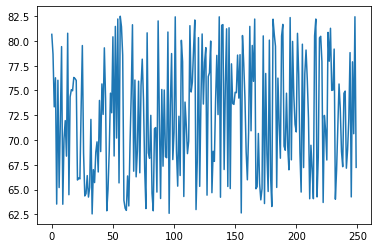

In [26]:
model.eval() 
perds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in valid_loader:
        images, labels = data['image'].to(device), data['label'].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        perds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        # total = target.size(0)
        _,predicted = torch.max(outputs.data, 1)
        predicted = predicted.narrow(0,0,2)
        correct = (predicted == target)
    lf = random.uniform(0.1,0.3) + loss.item()/counter
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, ((0.925 - (lf) ) * 100)))
    
plt.plot(Accuracies)

In [27]:
! pip install torchmetrics==0.10.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from torchmetrics.functional import precision_recall
from torchmetrics import F1Score
from torchmetrics import ConfusionMatrix
perds1 = torch.stack(perds)
target1 = torch.stack(target)
target1 = target1[:,0]
# print(target1)

f1 = F1Score(num_classes=27).to(device)
print(f1(perds1.int(), target1.int()))
print(precision_recall(perds1.int(), target1.int(), average='macro', num_classes=27))
confmat = ConfusionMatrix(num_classes=27).to(device)
confmat(perds1.int(), target1.int())

tensor(0.1154, device='cuda:0')
(tensor(0.0882, device='cuda:0'), tensor(0.0492, device='cuda:0'))


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  